# FX vol trading strategy - implementation

In [1]:
# Import libraries

from data_cleaning.import_data import import_data
from utils.garch import get_rolling_vol_forecasts
from utils.plots import plot_trades, plot_grid_forecasted_vs_realized
from utils.statistics import forecasting_accuracy
from utils.trading_strategy import gen_trading_signals, calc_pnl
from arch import arch_model

import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

In [19]:
fx_pairs =[
    'USDRUB',
    'USDZAR',
    'USDBRL',
    'EURUSD',
    'USDJPY',
    'GBPUSD'
]

## Forecast volatility

In [21]:
dfs = { pair : import_data(fx_pair=pair) for pair in fx_pairs }
# generate volatility forecasts
for pair, df in dfs.items():
    if pair =='BRLUSD': continue
    return_series = dfs[pair].dropna()['log_ret'] * 100 
    print('\n', pair)
    #model = arch_model(return_series, vol='GARCH', p=1, q=1, dist='Studentst')  # every pair gets a GARCH(1,1) cf. Lunde
    model = arch_model(return_series, vol='GARCH', p=1, q=1, o=1, dist='Studentst')  
    #model = arch_model(return_series, vol='FIGARCH', p=1, q=1, dist='Studentst')  

    
    # Conditional volatility forecasting
    vol_forecasts = get_rolling_vol_forecasts(return_series=return_series,
                                                model = model, 
                                                horizon=21,
                                                fitting_end_date="2021-01-01",
                                                ) # rolling forecast to get sequential 21-days-ahead conditional volatility forecasts
    dfs[pair] = dfs[pair].merge(vol_forecasts['h.21'], left_index=True, right_index=True)
    dfs[pair].rename(columns={'h.21':'cond_vol_forecast'},inplace=True)
    dfs[pair]['cond_forecast_to_implied'] = dfs[pair]['cond_vol_forecast'] / dfs[pair]['v1m']



 USDRUB

Fitting rolling GJR-GARCH(p: 1, o: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................................................................................................................................................................................................................................................
 USDZAR

Fitting rolling GJR-GARCH(p: 1, o: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................................................................................................................................................................................................................................................
 USDBRL

Fitting rolling GJR-GARCH(p: 1, o: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................

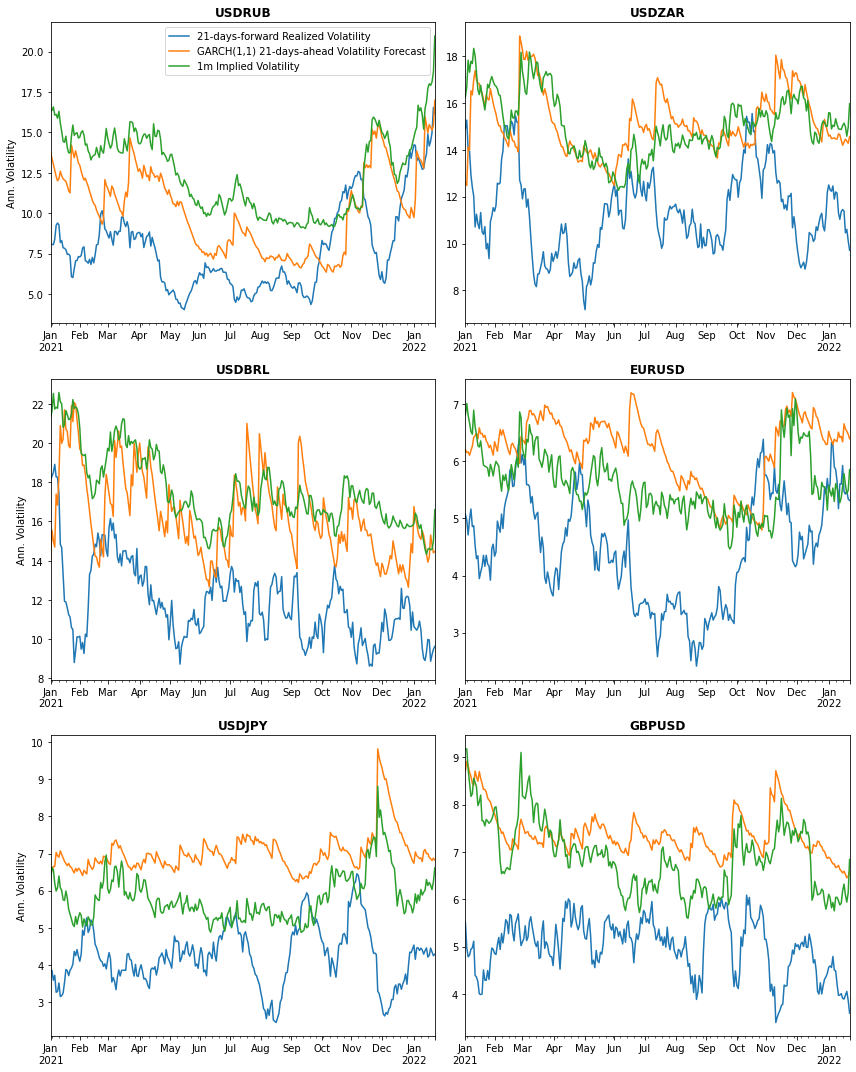

In [12]:
plot_grid_forecasted_vs_realized(df_dict=dfs, implied=True)

## Generate trading signals

We start by looking at 1 pair, e.g. USDRUB.

We can either hold to maturity (``days_holding_period`` $=21$) and get: 
$$ PnL = sign(direction) * (realized^{\ next \ 21 \ days} - implied^{\ now}) - 2 * spread $$

or we can close trade by going opposite direction after ``days_holding_period``$ = 0<x<21$ days and get:
$$ PnL = sign(direction) * (implied^{\ in \ x \ days} - implied^{\ now}) - 2 * spread $$


In [13]:
threshold_up = 1.10
threshold_down = 0.90
days_holding_period = 21 # 21
pair = 'USDBRL'
df = dfs[pair].copy(deep=True)

In [14]:
gen_trading_signals(df, thres_up=threshold_up,thres_down=threshold_down, days_holding_period = days_holding_period)
df.tail(10)

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,forward_rolling_21d_realized_stdev,normalized_bid_ask_spread,cond_vol_forecast,cond_forecast_to_implied,direction,gearing,returns,returns_w_gearing,direction_flag
2022-01-11,15.343,15.495,17.198,5.5730,5.5726,5.5735,-0.017273,10.445824,9.522999,0.016149,15.518472,1.011437,0,0.000000,-0.032298,-0.032298,nan
2022-01-12,14.993,15.230,17.002,5.5203,5.5200,5.5205,-0.009501,10.984476,9.021069,0.009058,15.291818,1.019931,0,0.000000,-0.018115,-0.018115,nan
2022-01-13,14.575,15.095,16.938,5.5289,5.5282,5.5295,0.001557,11.046326,8.913476,0.023513,14.821363,1.016903,0,0.000000,-0.047026,-0.047026,nan
2022-01-14,14.330,14.997,16.763,5.5280,5.5276,5.5285,-0.000163,11.032044,9.335899,0.016281,14.354653,1.001720,0,0.000000,-0.032561,-0.032561,nan
2022-01-17,14.590,15.105,16.800,5.5230,5.5225,5.5235,-0.000905,11.081837,9.990822,0.018106,13.925494,0.954455,0,0.000000,-0.036212,-0.036212,nan
2022-01-18,14.635,14.930,16.807,5.5681,5.5675,5.5686,0.008133,11.009741,9.961798,0.019756,14.183173,0.969127,0,0.000000,-0.039511,-0.039511,nan
2022-01-19,14.555,14.900,16.802,5.4461,5.4455,5.4466,-0.022154,12.590954,8.880165,0.020198,15.309920,1.051867,0,0.000000,-0.040396,-0.040396,nan
2022-01-20,14.577,15.042,16.995,5.4372,5.4368,5.4375,-0.001636,11.593122,9.209715,0.012874,14.810812,1.016040,0,0.000000,-0.025749,-0.025749,nan
2022-01-21,15.003,15.267,17.110,5.4515,5.4510,5.4520,0.002627,11.566311,9.489284,0.018344,14.405814,0.960196,0,0.000000,-0.036687,-0.036687,nan
2022-01-24,16.605,16.415,17.530,5.4909,5.4904,5.4914,0.007201,12.110684,9.637924,0.018212,14.466200,0.871195,-1,1.117095,6.930652,7.746462,Sold straddle


## How does the trades look?

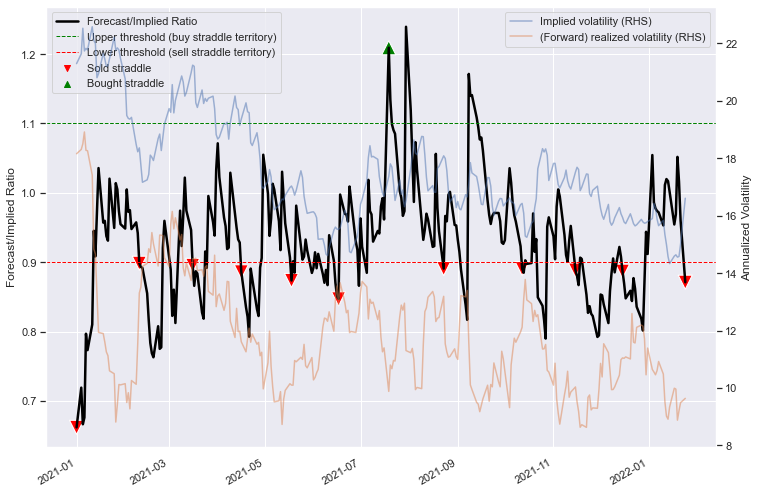

In [17]:
plot_trades(df=df,
            thres_up=threshold_up,
            thres_down=threshold_down, 
            include_implied=True, 
            #include_forecasted=True,
            include_realized=True,
            )

As can be seen from the graph, we are short vol the whole period due to the thresholds....

Number of trades:  12
Mean return 4.05%
Mean bid-ask spread 0.03%
Normalized PnL: 65.84%
Normalized PnL w. Gearing: 74.46%


,direction,v1m,forward_rolling_21d_realized_stdev,normalized_bid_ask_spread,gearing,returns,returns_w_gearing,normalized_pnl,normalized_pnl_w_gearing
2020-12-31,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-01,-1,21.290,18.152996,0.071175,1.307229,2.994654,3.958431,0.029947,0.039584
2021-02-10,-1,18.358,13.303632,0.024142,1.092256,5.006084,5.472379,0.081507,0.096474
2021-03-16,-1,21.237,14.498947,0.032001,1.095004,6.674052,7.314192,0.153687,0.176673
2021-04-16,-1,19.362,11.607092,0.032211,1.103462,7.690486,8.492825,0.242411,0.276605
2021-05-18,-1,17.030,10.100201,0.028510,1.114749,6.872779,7.667965,0.327799,0.374495
2021-06-17,-1,15.523,12.902073,0.011980,1.138825,2.596967,2.960816,0.362282,0.415191
2021-07-19,1,17.362,9.880722,0.026658,1.190180,-7.534595,-8.957383,0.259639,0.288427
2021-08-23,-1,18.080,13.190142,0.037171,1.099204,4.815515,5.300608,0.320297,0.356722
2021-10-12,-1,16.425,12.116334,0.025275,1.099252,4.258116,4.685758,0.376517,0.420294


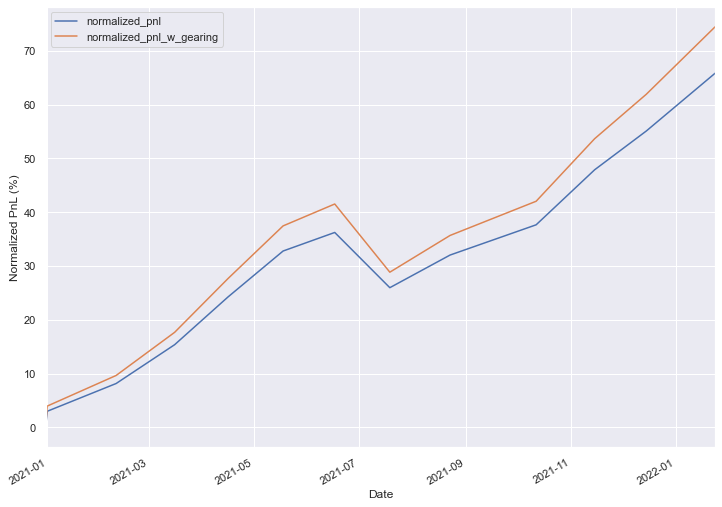

In [18]:
calc_pnl(df,plot=True)

### Overview (trying different strategies)

In [ ]:
threshold_up = [1.05, 1.1, 1.2, 1.3]
threshold_down = [0.95, 0.9, 0.8, 0.7]
days_holding_period = 21

In [ ]:
for pair in dfs.keys():
    if pair == 'BRLUSD': continue
    print(pair)
    df = dfs[pair].copy(deep=True)

    for up, down in zip(threshold_up, threshold_down):
        print(f"{up}/{down}")
        gen_trading_signals(df, thres_up=up,thres_down=down, days_holding_period = days_holding_period)
        calc_pnl(df,plot=False, return_df=False)
        print('--------------\n')

BRL

In [ ]:
threshold_up = 1.05
threshold_down = 0.95
days_holding_period = 21 # 21
pair = 'USDBRL'
df_05 = dfs[pair].copy(deep=True)

In [ ]:
gen_trading_signals(df_05, thres_up=threshold_up,thres_down=threshold_down, days_holding_period = days_holding_period)
df_05.tail(10)

In [ ]:
threshold_up = 1.10
threshold_down = 0.90
days_holding_period = 21 # 21
pair = 'USDBRL'
df_10 = dfs[pair].copy(deep=True)

In [ ]:
gen_trading_signals(df_10, thres_up=threshold_up,thres_down=threshold_down, days_holding_period = days_holding_period)
df_10.tail(10)

In [ ]:
import seaborn as sns
import pandas as pd
# function for plotting quotes

sns.set(rc={"figure.figsize": (12, 9)})
#plt.title(f"Forecast/Implied Ratio (including traded straddles)", fontweight='bold')  # {pair} 

# ratio
ax1 = sns.lineplot(
    data=df_05,
    x=df.index,
    y="cond_forecast_to_implied",
    color="black",
    label="Forecast/Implied Ratio",
    lw=2.0,
)
# thresholds
ax1.axhline(1.05, linestyle='--', color='green', linewidth=1, label='Upper threshold (+5%)')
ax1.axhline(0.95, linestyle='--', color='red', linewidth=1, label='Lower threshold (-5%)')
ax1.axhline(1.10, linestyle='--', color='lime', linewidth=1, label='Upper threshold (+10%)')
ax1.axhline(0.90, linestyle='--', color='magenta', linewidth=1, label='Lower threshold (-5%)')

# straddles bought and sold
markers = {"Bought straddle": "^", "Sold straddle": "v"}
color_dict = dict(
    {
        "Bought straddle": "green",
        "Sold straddle": "red",
    }
)
sns.scatterplot(
    data=df_05.query("direction_flag in ('Bought straddle','Sold straddle')"),  
    x=df_05.query("direction_flag in ('Bought straddle','Sold straddle')").index,
    y="cond_forecast_to_implied", 
    hue="direction_flag", 
    style="direction_flag", 
    markers=markers, 
    s=200, 
    palette=color_dict,
    ax = ax1
)

color_dict = dict(
    {
        "Bought straddle": "lime",
        "Sold straddle": "magenta",
    }
)
sns.scatterplot(
    data=df_10.query("direction_flag in ('Bought straddle','Sold straddle')"),  
    x=df_10.query("direction_flag in ('Bought straddle','Sold straddle')").index,
    y="cond_forecast_to_implied", 
    hue="direction_flag", 
    style="direction_flag", 
    markers=markers, 
    s=200, 
    palette=color_dict,
    ax = ax1, 
)



ax1.legend(title='', loc='upper left',)
ax1.set_ylabel('Forecast/Implied Ratio')

# implied volatility and forecasted volatility
ax2 = ax1.twinx()
sns.lineplot(
    x=df.index,
    y=df_10['v1m']-df_10['forward_rolling_21d_realized_stdev'],
    #color="darkorange",
    label="Implied minus realized volatility (RHS)",
    lw=1.5,
    alpha=0.5,
    ax=ax2
)

ax2.legend(title='', loc='upper right')
ax2.set_ylabel('Annualized Volatility Points Difference')
ax2.grid(False)


# last finishing off
plt.gcf().autofmt_xdate()
plt.show()


## How does the trades look?

In [ ]:
plot_trades(df=df,
            thres_up=threshold_up,
            thres_down=threshold_down, 
            include_implied=True, 
            #include_forecasted=True,
            include_realized=True,
            )